In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.models.segmentation as models
from torchinfo import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMAGE_PATH = r"/kaggle/input/fireee/data/fire"
MASK_PATH = r"/kaggle/input/fireee/data/mask"

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32  
EPOCHS = 50      
LEARNING_RATE = 0.0001
N_CLASSES = 1    
MODEL_NAME = 'pytorch_deeplabv3_fire_segmentation.pth'

print(f"Using device: {DEVICE}")
print(f"Image path set to: {IMAGE_PATH}")
print(f"Mask path set to: {MASK_PATH}")

Using device: cuda
Image path set to: /kaggle/input/fireee/data/fire
Mask path set to: /kaggle/input/fireee/data/mask


In [3]:
image_files = sorted(glob.glob(os.path.join(IMAGE_PATH, '*.jpg')))
mask_files = sorted(glob.glob(os.path.join(MASK_PATH, '*.png')))

df = pd.DataFrame({'image_path': image_files, 'mask_path': mask_files})
print(f"Found {len(df)} image/mask pairs.")
print("DataFrame created successfully:")
df.head()

Found 2110 image/mask pairs.
DataFrame created successfully:


,image_path,mask_path
0,/kaggle/input/fireee/data/fire/F_0.jpg,/kaggle/input/fireee/data/mask/F_0.png
1,/kaggle/input/fireee/data/fire/F_1.jpg,/kaggle/input/fireee/data/mask/F_1.png
2,/kaggle/input/fireee/data/fire/F_10.jpg,/kaggle/input/fireee/data/mask/F_10.png
3,/kaggle/input/fireee/data/fire/F_100.jpg,/kaggle/input/fireee/data/mask/F_100.png
4,/kaggle/input/fireee/data/fire/F_1000.jpg,/kaggle/input/fireee/data/mask/F_1000.png


In [4]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 1266
Validation set size: 422
Test set size: 422


In [5]:
class FireDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = cv2.imread(row.image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(row.mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Ensure mask is binary 0 or 1 and cast to float32
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask.unsqueeze(0) # Add a channel dimension to the mask

# Define augmentations
train_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.Rotate(limit=35, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2(),
])

val_test_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2(),
])

print("PyTorch Dataset and Augmentations defined.")

PyTorch Dataset and Augmentations defined.


In [6]:
train_dataset = FireDataset(train_df, transform=train_transform)
val_dataset = FireDataset(val_df, transform=val_test_transform)
test_dataset = FireDataset(test_df, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
def build_model():
    model = models.deeplabv3_resnet50(weights=models.DeepLabV3_ResNet50_Weights.DEFAULT)
    # Replace the classifier for our number of classes (1 for fire)
    model.classifier[4] = nn.Conv2d(256, N_CLASSES, kernel_size=(1, 1), stride=(1, 1))
    return model

model = build_model().to(DEVICE)
print("Model built and sent to device.")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 81.1MB/s] 


Model built and sent to device.


In [8]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def calculate_metrics(loader, model, loss_fn, device="cuda"):
    model.eval()
    total_loss = 0
    
    all_preds, all_targets = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            
            preds = model(x)['out']
            loss = loss_fn(preds, y)
            total_loss += loss.item()
            
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            
            all_preds.append(preds.view(-1))
            all_targets.append(y.view(-1))

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    tp = (all_preds * all_targets).sum()
    fp = ((1 - all_targets) * all_preds).sum()
    fn = (all_targets * (1 - all_preds)).sum()
    tn = ((1 - all_targets) * (1 - all_preds)).sum()
    
    # Calculate metrics
    epsilon = 1e-7
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    dice = (2 * tp) / (2 * tp + fp + fn + epsilon)
    iou = tp / (tp + fp + fn + epsilon)
    
    avg_loss = total_loss / len(loader)
    
    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy.item(),
        'dice_coefficient': dice.item(),
        'iou_metric': iou.item()
    }
    
    return metrics

print("Loss function, optimizer, and metrics defined.")

Loss function, optimizer, and metrics defined.


In [9]:
best_val_dice = 0.0
history = {
    'train_loss': [], 'train_accuracy': [], 'train_dice_coefficient': [], 'train_iou_metric': [],
    'val_loss': [], 'val_accuracy': [], 'val_dice_coefficient': [], 'val_iou_metric': []
}

if not df.empty:
    for epoch in range(EPOCHS):
        model.train()
        train_loss_sum = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        
        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device=DEVICE)
            targets = targets.float().to(device=DEVICE)

            # Forward pass
            predictions = model(data)['out']
            loss = loss_fn(predictions, targets)
            train_loss_sum += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update tqdm loop
            loop.set_postfix(loss=loss.item())
            
        # --- Validation and Metric Calculation at End of Epoch ---
        train_metrics = calculate_metrics(train_loader, model, loss_fn, device=DEVICE)
        val_metrics = calculate_metrics(val_loader, model, loss_fn, device=DEVICE)

        history['train_loss'].append(train_metrics['loss'])
        history['train_accuracy'].append(train_metrics['accuracy'])
        history['train_dice_coefficient'].append(train_metrics['dice_coefficient'])
        history['train_iou_metric'].append(train_metrics['iou_metric'])
        
        history['val_loss'].append(val_metrics['loss'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_dice_coefficient'].append(val_metrics['dice_coefficient'])
        history['val_iou_metric'].append(val_metrics['iou_metric'])
        
        val_dice = val_metrics['dice_coefficient']
        
        print(f"Epoch {epoch+1} - Train Loss: {train_metrics['loss']:.4f}, Val Loss: {val_metrics['loss']:.4f}, Val Dice: {val_dice:.4f}")

        # Save the best model based on validation dice score
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), MODEL_NAME)
            print(f"==> Best model saved with Dice Score: {best_val_dice:.4f}")

    print("Model training complete.")
else:
    print("Training skipped because no data was loaded.")

Epoch 1/50: 100%|██████████| 40/40 [01:25<00:00,  2.14s/it, loss=0.299]


Epoch 1 - Train Loss: 0.4410, Val Loss: 0.4289, Val Dice: 0.7591
==> Best model saved with Dice Score: 0.7591


Epoch 2/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.242]


Epoch 2 - Train Loss: 0.2057, Val Loss: 0.2064, Val Dice: 0.8653
==> Best model saved with Dice Score: 0.8653


Epoch 3/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.199]


Epoch 3 - Train Loss: 0.1874, Val Loss: 0.1892, Val Dice: 0.8808
==> Best model saved with Dice Score: 0.8808


Epoch 4/50: 100%|██████████| 40/40 [01:05<00:00,  1.65s/it, loss=0.153]


Epoch 4 - Train Loss: 0.1626, Val Loss: 0.1644, Val Dice: 0.8969
==> Best model saved with Dice Score: 0.8969


Epoch 5/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.199]


Epoch 5 - Train Loss: 0.1440, Val Loss: 0.1452, Val Dice: 0.9046
==> Best model saved with Dice Score: 0.9046


Epoch 6/50: 100%|██████████| 40/40 [01:05<00:00,  1.65s/it, loss=0.192]


Epoch 6 - Train Loss: 0.1366, Val Loss: 0.1383, Val Dice: 0.9080
==> Best model saved with Dice Score: 0.9080


Epoch 7/50: 100%|██████████| 40/40 [01:05<00:00,  1.65s/it, loss=0.122]


Epoch 7 - Train Loss: 0.1322, Val Loss: 0.1329, Val Dice: 0.9011


Epoch 8/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.139]


Epoch 8 - Train Loss: 0.1120, Val Loss: 0.1135, Val Dice: 0.9137
==> Best model saved with Dice Score: 0.9137


Epoch 9/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.103]


Epoch 9 - Train Loss: 0.1073, Val Loss: 0.1085, Val Dice: 0.9174
==> Best model saved with Dice Score: 0.9174


Epoch 10/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.12]  


Epoch 10 - Train Loss: 0.1001, Val Loss: 0.1013, Val Dice: 0.9201
==> Best model saved with Dice Score: 0.9201


Epoch 11/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0946]


Epoch 11 - Train Loss: 0.0982, Val Loss: 0.0994, Val Dice: 0.9200


Epoch 12/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0911]


Epoch 12 - Train Loss: 0.0943, Val Loss: 0.0956, Val Dice: 0.9204
==> Best model saved with Dice Score: 0.9204


Epoch 13/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0976]


Epoch 13 - Train Loss: 0.0876, Val Loss: 0.0892, Val Dice: 0.9244
==> Best model saved with Dice Score: 0.9244


Epoch 14/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.0975]


Epoch 14 - Train Loss: 0.0819, Val Loss: 0.0838, Val Dice: 0.9248
==> Best model saved with Dice Score: 0.9248


Epoch 15/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.0874]


Epoch 15 - Train Loss: 0.0828, Val Loss: 0.0846, Val Dice: 0.9238


Epoch 16/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.0989]


Epoch 16 - Train Loss: 0.0795, Val Loss: 0.0813, Val Dice: 0.9263
==> Best model saved with Dice Score: 0.9263


Epoch 17/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0902]


Epoch 17 - Train Loss: 0.0769, Val Loss: 0.0786, Val Dice: 0.9272
==> Best model saved with Dice Score: 0.9272


Epoch 18/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.107] 


Epoch 18 - Train Loss: 0.0745, Val Loss: 0.0760, Val Dice: 0.9271


Epoch 19/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.103] 


Epoch 19 - Train Loss: 0.0719, Val Loss: 0.0738, Val Dice: 0.9265


Epoch 20/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0649]


Epoch 20 - Train Loss: 0.0704, Val Loss: 0.0726, Val Dice: 0.9280
==> Best model saved with Dice Score: 0.9280


Epoch 21/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.0828]


Epoch 21 - Train Loss: 0.0685, Val Loss: 0.0699, Val Dice: 0.9303
==> Best model saved with Dice Score: 0.9303


Epoch 22/50: 100%|██████████| 40/40 [01:05<00:00,  1.65s/it, loss=0.0591]


Epoch 22 - Train Loss: 0.0698, Val Loss: 0.0724, Val Dice: 0.9273


Epoch 23/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0654]


Epoch 23 - Train Loss: 0.0655, Val Loss: 0.0681, Val Dice: 0.9295


Epoch 24/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.0726]


Epoch 24 - Train Loss: 0.0650, Val Loss: 0.0670, Val Dice: 0.9309
==> Best model saved with Dice Score: 0.9309


Epoch 25/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0769]


Epoch 25 - Train Loss: 0.0672, Val Loss: 0.0688, Val Dice: 0.9287


Epoch 26/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.105] 


Epoch 26 - Train Loss: 0.0629, Val Loss: 0.0647, Val Dice: 0.9293


Epoch 27/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0955]


Epoch 27 - Train Loss: 0.0639, Val Loss: 0.0655, Val Dice: 0.9317
==> Best model saved with Dice Score: 0.9317


Epoch 28/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.076] 


Epoch 28 - Train Loss: 0.0613, Val Loss: 0.0631, Val Dice: 0.9323
==> Best model saved with Dice Score: 0.9323


Epoch 29/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.0941]


Epoch 29 - Train Loss: 0.0608, Val Loss: 0.0633, Val Dice: 0.9322


Epoch 30/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0684]


Epoch 30 - Train Loss: 0.0620, Val Loss: 0.0643, Val Dice: 0.9317


Epoch 31/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0537]


Epoch 31 - Train Loss: 0.0608, Val Loss: 0.0630, Val Dice: 0.9313


Epoch 32/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.0692]


Epoch 32 - Train Loss: 0.0596, Val Loss: 0.0622, Val Dice: 0.9328
==> Best model saved with Dice Score: 0.9328


Epoch 33/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.0849]


Epoch 33 - Train Loss: 0.0612, Val Loss: 0.0638, Val Dice: 0.9271


Epoch 34/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.104] 


Epoch 34 - Train Loss: 0.0587, Val Loss: 0.0610, Val Dice: 0.9320


Epoch 35/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0534]


Epoch 35 - Train Loss: 0.0580, Val Loss: 0.0604, Val Dice: 0.9333
==> Best model saved with Dice Score: 0.9333


Epoch 36/50: 100%|██████████| 40/40 [01:06<00:00,  1.65s/it, loss=0.0536]


Epoch 36 - Train Loss: 0.0579, Val Loss: 0.0599, Val Dice: 0.9345
==> Best model saved with Dice Score: 0.9345


Epoch 37/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0745]


Epoch 37 - Train Loss: 0.0568, Val Loss: 0.0592, Val Dice: 0.9338


Epoch 38/50: 100%|██████████| 40/40 [01:06<00:00,  1.65s/it, loss=0.0496]


Epoch 38 - Train Loss: 0.0596, Val Loss: 0.0615, Val Dice: 0.9281


Epoch 39/50: 100%|██████████| 40/40 [01:05<00:00,  1.65s/it, loss=0.0627]


Epoch 39 - Train Loss: 0.0561, Val Loss: 0.0590, Val Dice: 0.9331


Epoch 40/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0606]


Epoch 40 - Train Loss: 0.0558, Val Loss: 0.0580, Val Dice: 0.9356
==> Best model saved with Dice Score: 0.9356


Epoch 41/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0522]


Epoch 41 - Train Loss: 0.0558, Val Loss: 0.0587, Val Dice: 0.9340


Epoch 42/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0539]


Epoch 42 - Train Loss: 0.0542, Val Loss: 0.0574, Val Dice: 0.9344


Epoch 43/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0905]


Epoch 43 - Train Loss: 0.0548, Val Loss: 0.0575, Val Dice: 0.9351


Epoch 44/50: 100%|██████████| 40/40 [01:06<00:00,  1.67s/it, loss=0.0685]


Epoch 44 - Train Loss: 0.0546, Val Loss: 0.0577, Val Dice: 0.9354


Epoch 45/50: 100%|██████████| 40/40 [01:06<00:00,  1.66s/it, loss=0.0424]


Epoch 45 - Train Loss: 0.0543, Val Loss: 0.0583, Val Dice: 0.9326


Epoch 46/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.0672]


Epoch 46 - Train Loss: 0.0537, Val Loss: 0.0568, Val Dice: 0.9357
==> Best model saved with Dice Score: 0.9357


Epoch 47/50: 100%|██████████| 40/40 [01:05<00:00,  1.65s/it, loss=0.0472]


Epoch 47 - Train Loss: 0.0551, Val Loss: 0.0583, Val Dice: 0.9352


Epoch 48/50: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it, loss=0.0551]


Epoch 48 - Train Loss: 0.0527, Val Loss: 0.0560, Val Dice: 0.9360
==> Best model saved with Dice Score: 0.9360


Epoch 49/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0494]


Epoch 49 - Train Loss: 0.0535, Val Loss: 0.0570, Val Dice: 0.9363
==> Best model saved with Dice Score: 0.9363


Epoch 50/50: 100%|██████████| 40/40 [01:05<00:00,  1.64s/it, loss=0.0516]


Epoch 50 - Train Loss: 0.0516, Val Loss: 0.0550, Val Dice: 0.9373
==> Best model saved with Dice Score: 0.9373
Model training complete.


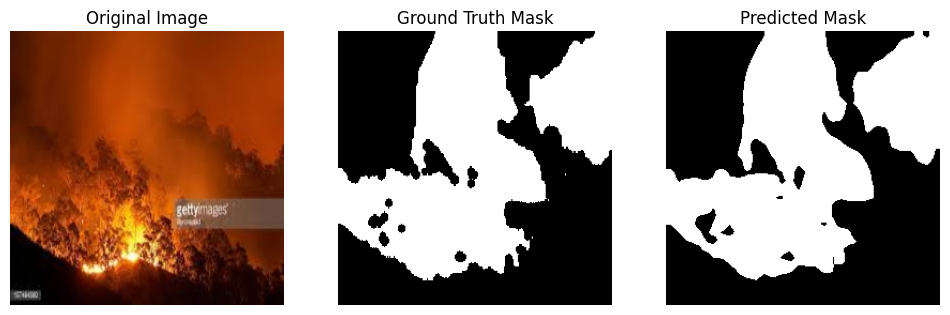

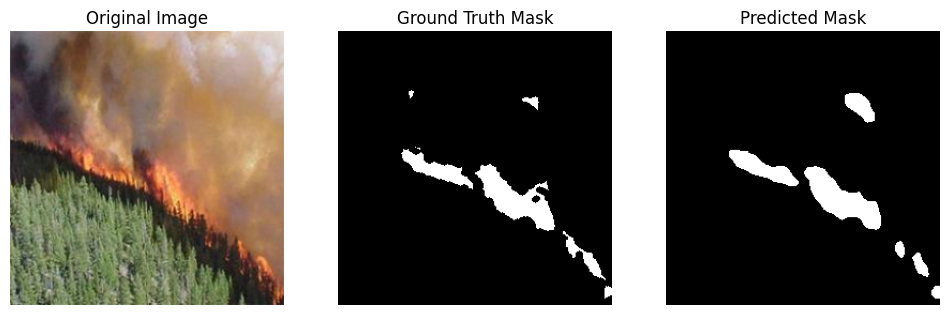

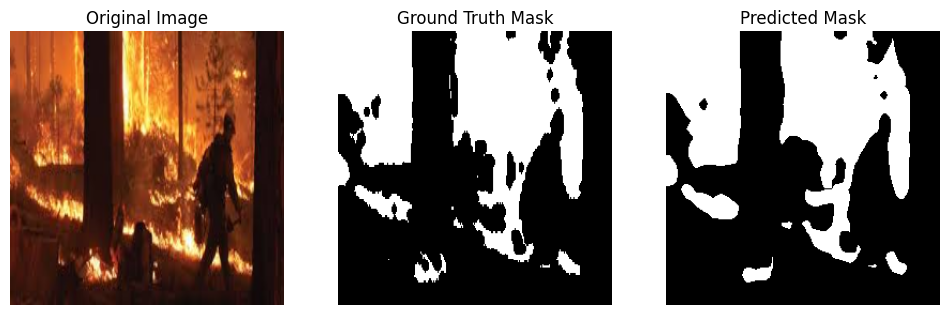

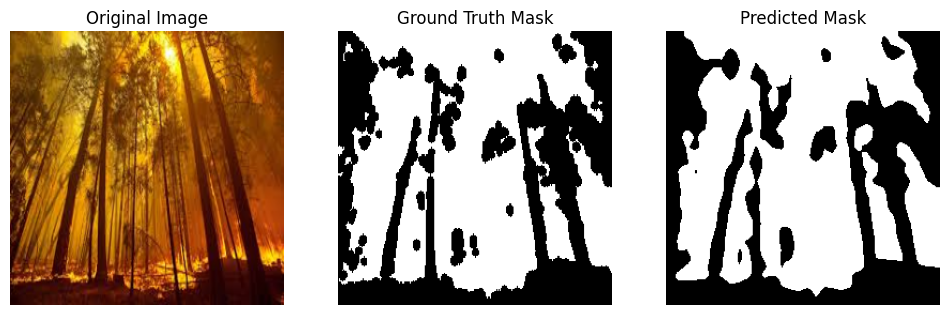

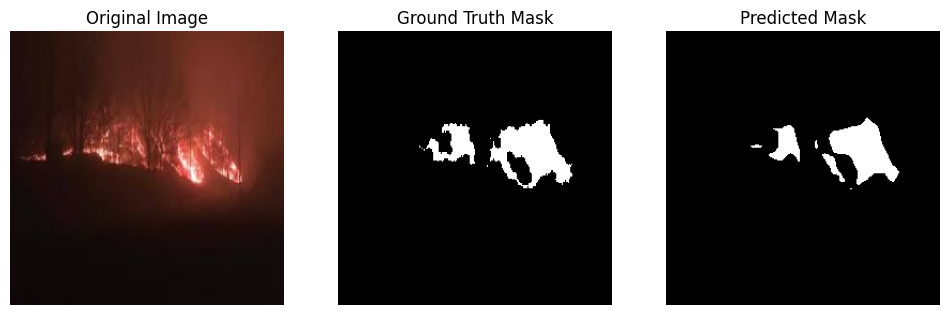

In [10]:
model.load_state_dict(torch.load(MODEL_NAME))
model.to(DEVICE)

def visualize_predictions(loader, model, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            if i >= num_images:
                break
            
            x = x.to(DEVICE)
            preds = torch.sigmoid(model(x)['out'])
            preds = (preds > 0.5).float().cpu()

            for j in range(x.size(0)):
                if i * loader.batch_size + j >= num_images:
                    break
                
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1); plt.imshow(x[j].permute(1, 2, 0).cpu().numpy()); plt.title('Original Image'); plt.axis('off')
                plt.subplot(1, 3, 2); plt.imshow(y[j].squeeze(), cmap='gray'); plt.title('Ground Truth Mask'); plt.axis('off')
                plt.subplot(1, 3, 3); plt.imshow(preds[j].squeeze(), cmap='gray'); plt.title('Predicted Mask'); plt.axis('off')
                plt.show()

visualize_predictions(test_loader, model, num_images=5)

In [11]:
print("="*65)
print("MODEL ARCHITECTURE")
print("="*65)
summary(model, input_size=(BATCH_SIZE, 3, IMG_HEIGHT, IMG_WIDTH))

MODEL ARCHITECTURE


Layer (type:depth-idx)                             Output Shape              Param #
DeepLabV3                                          [32, 21, 256, 256]        --
├─IntermediateLayerGetter: 1-1                     [32, 2048, 32, 32]        --
│    └─Conv2d: 2-1                                 [32, 64, 128, 128]        9,408
│    └─BatchNorm2d: 2-2                            [32, 64, 128, 128]        128
│    └─ReLU: 2-3                                   [32, 64, 128, 128]        --
│    └─MaxPool2d: 2-4                              [32, 64, 64, 64]          --
│    └─Sequential: 2-5                             [32, 256, 64, 64]         --
│    │    └─Bottleneck: 3-1                        [32, 256, 64, 64]         75,008
│    │    └─Bottleneck: 3-2                        [32, 256, 64, 64]         70,400
│    │    └─Bottleneck: 3-3                        [32, 256, 64, 64]         70,400
│    └─Sequential: 2-6                             [32, 512, 32, 32]         --
│    │    └─Bottlen

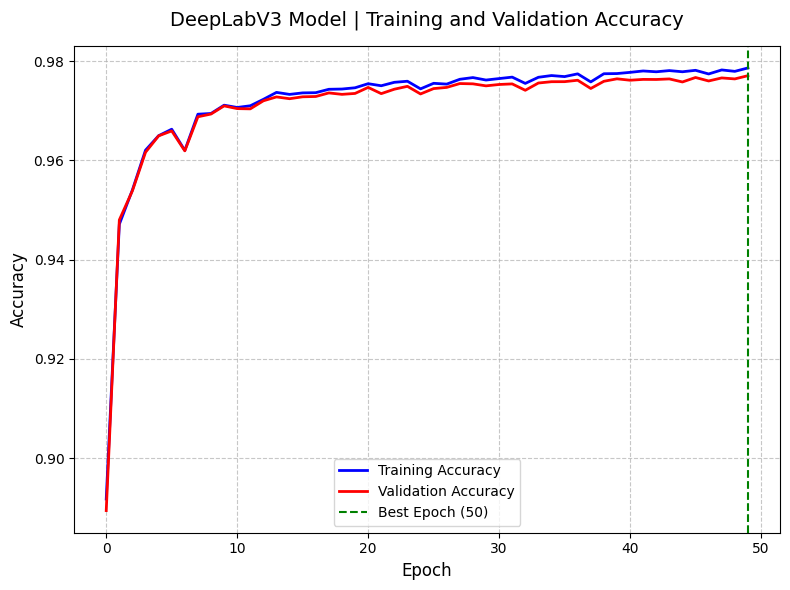

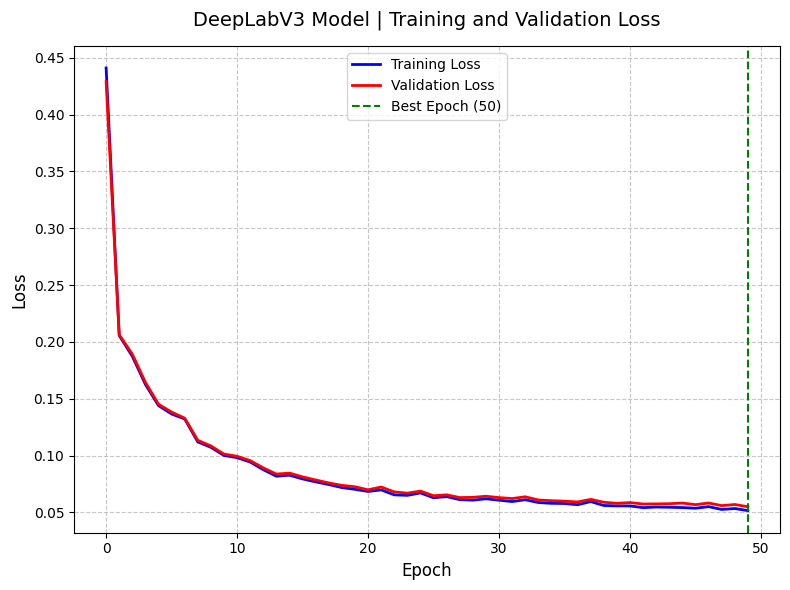

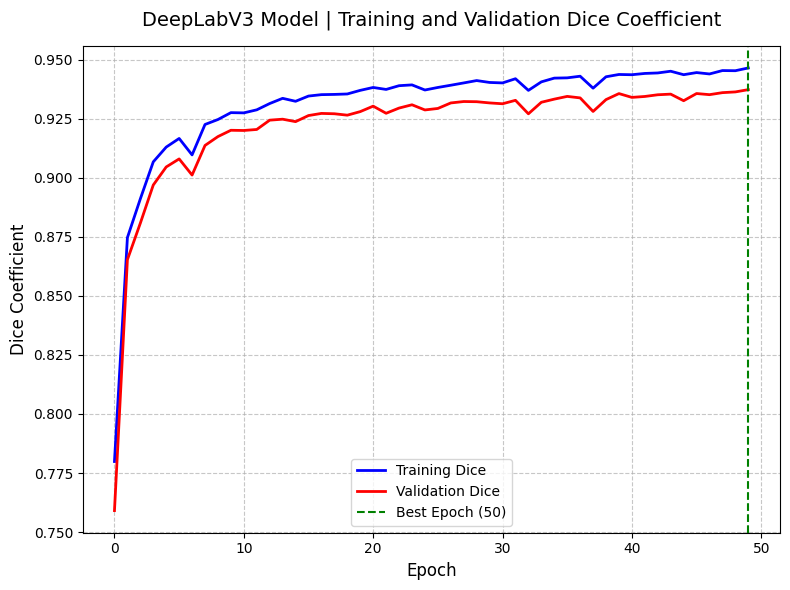

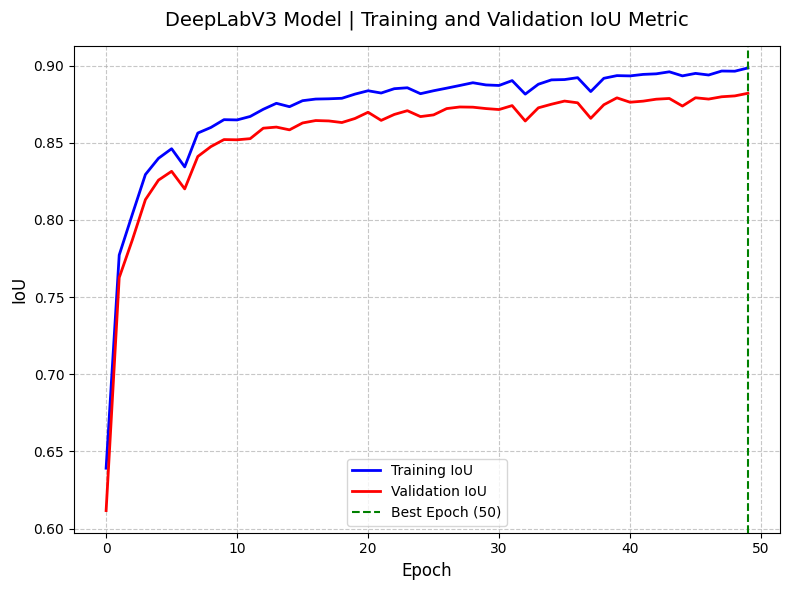


Best Epochs Summary:
--------------------------------------------------
Loss - Epoch:  50, Value: 0.0550
Dice - Epoch:  50, Value: 0.9373
IoU - Epoch:  50, Value: 0.8820
Accuracy - Epoch:  50, Value: 0.9771


In [12]:
if not df.empty and history['train_loss']: # Check if history has been populated
    history_df = pd.DataFrame(history)

    # Get the best epochs for each metric
    best_val_loss_epoch = history_df['val_loss'].idxmin() + 1
    best_val_dice_epoch = history_df['val_dice_coefficient'].idxmax() + 1
    best_val_iou_epoch = history_df['val_iou_metric'].idxmax() + 1
    best_val_acc_epoch = history_df['val_accuracy'].idxmax() + 1

    # Calculate the best metric values
    min_val_loss = history_df['val_loss'].min()
    max_val_dice = history_df['val_dice_coefficient'].max()
    max_val_iou = history_df['val_iou_metric'].max()
    max_val_acc = history_df['val_accuracy'].max()

    # Plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history_df['train_accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(history_df['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    plt.axvline(x=best_val_acc_epoch - 1, color='g', linestyle='--', label=f'Best Epoch ({best_val_acc_epoch})')
    plt.title('DeepLabV3 Model | Training and Validation Accuracy', fontsize=14, pad=15)
    plt.xlabel('Epoch', fontsize=12); plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()

    # Plot Loss
    plt.figure(figsize=(8, 6))
    plt.plot(history_df['train_loss'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(history_df['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    plt.axvline(x=best_val_loss_epoch - 1, color='g', linestyle='--', label=f'Best Epoch ({best_val_loss_epoch})')
    plt.title('DeepLabV3 Model | Training and Validation Loss', fontsize=14, pad=15)
    plt.xlabel('Epoch', fontsize=12); plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()

    # Plot Dice Coefficient
    plt.figure(figsize=(8, 6))
    plt.plot(history_df['train_dice_coefficient'], 'b-', label='Training Dice', linewidth=2)
    plt.plot(history_df['val_dice_coefficient'], 'r-', label='Validation Dice', linewidth=2)
    plt.axvline(x=best_val_dice_epoch - 1, color='g', linestyle='--', label=f'Best Epoch ({best_val_dice_epoch})')
    plt.title('DeepLabV3 Model | Training and Validation Dice Coefficient', fontsize=14, pad=15)
    plt.xlabel('Epoch', fontsize=12); plt.ylabel('Dice Coefficient', fontsize=12)
    plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()

    # Plot IoU
    plt.figure(figsize=(8, 6))
    plt.plot(history_df['train_iou_metric'], 'b-', label='Training IoU', linewidth=2)
    plt.plot(history_df['val_iou_metric'], 'r-', label='Validation IoU', linewidth=2)
    plt.axvline(x=best_val_iou_epoch - 1, color='g', linestyle='--', label=f'Best Epoch ({best_val_iou_epoch})')
    plt.title('DeepLabV3 Model | Training and Validation IoU Metric', fontsize=14, pad=15)
    plt.xlabel('Epoch', fontsize=12); plt.ylabel('IoU', fontsize=12)
    plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()

    # Print summary of best epochs and values
    print("\nBest Epochs Summary:")
    print("-" * 50)
    print(f"Loss - Epoch: {best_val_loss_epoch:3d}, Value: {min_val_loss:.4f}")
    print(f"Dice - Epoch: {best_val_dice_epoch:3d}, Value: {max_val_dice:.4f}")
    print(f"IoU - Epoch: {best_val_iou_epoch:3d}, Value: {max_val_iou:.4f}")
    print(f"Accuracy - Epoch: {best_val_acc_epoch:3d}, Value: {max_val_acc:.4f}")
else:
    print("Plotting skipped because no training history was generated.")

In [13]:
def calculate_all_metrics(loader, model, loss_fn, device="cuda"):
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)['out']
            loss = loss_fn(preds, y)
            total_loss += loss.item()
            preds = (torch.sigmoid(preds) > 0.5).float()
            all_preds.append(preds.view(-1))
            all_targets.append(y.view(-1))

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    tp = (all_preds * all_targets).sum()
    fp = ((1 - all_targets) * all_preds).sum()
    fn = (all_targets * (1 - all_preds)).sum()
    tn = ((1 - all_targets) * (1 - all_preds)).sum()
    
    epsilon = 1e-7
    metrics = {
        'Loss': total_loss / len(loader),
        'Accuracy': ((tp + tn) / (tp + tn + fp + fn + epsilon)).item(),
        'Precision': (tp / (tp + fp + epsilon)).item(),
        'Recall': (tp / (tp + fn + epsilon)).item(),
        'IoU': (tp / (tp + fp + fn + epsilon)).item(),
        'Dice': ((2 * tp) / (2 * tp + fp + fn + epsilon)).item()
    }
    return list(metrics.values())

print("Comprehensive metrics function defined.")

Comprehensive metrics function defined.



FINAL METRICS EVALUATION
Calculating metrics for Training Set...
Calculating metrics for Validation Set...
Calculating metrics for Test Set...

Metrics Comparison Across Datasets:
-----------------------------------------------------------------
Metric          Training        Validation      Test           
-----------------------------------------------------------------
Loss            0.0517          0.0550          0.0585         
Accuracy        0.9786          0.9771          0.9750         
Precision       0.9457          0.9371          0.9390         
Recall          0.9473          0.9375          0.9400         
IoU             0.8983          0.8820          0.8859         
Dice            0.9465          0.9373          0.9395         
-----------------------------------------------------------------


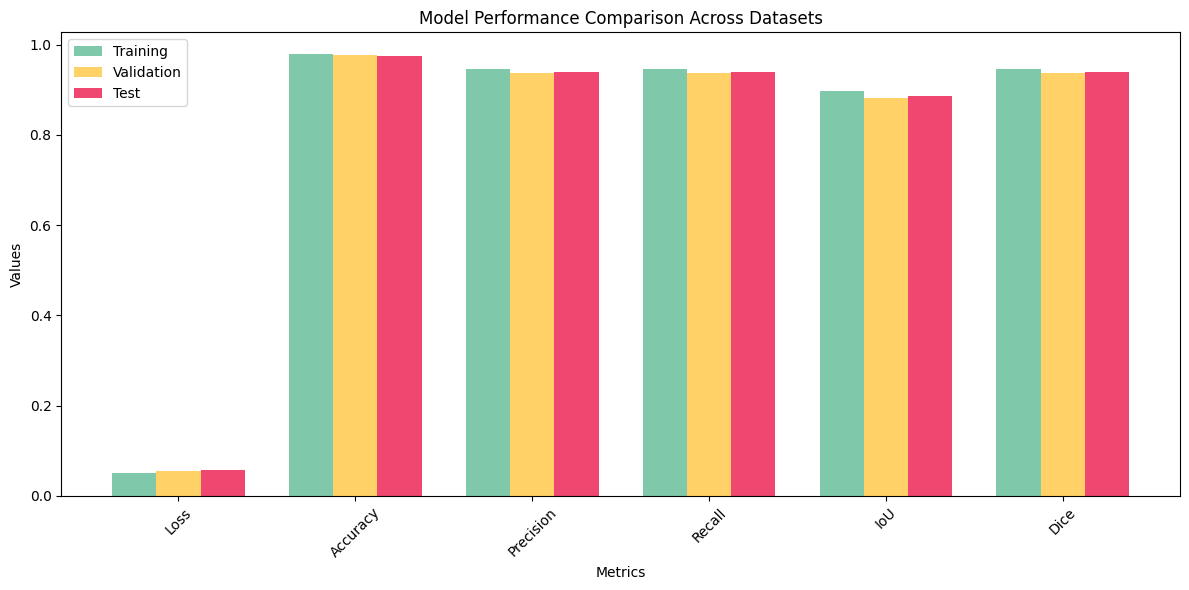

In [14]:
print("\n" + "="*65)
print("FINAL METRICS EVALUATION")
print("="*65)

# Store results for comparison
results_dict = {}
print("Calculating metrics for Training Set...")
results_dict['train'] = calculate_all_metrics(train_loader, model, loss_fn, device=DEVICE)
print("Calculating metrics for Validation Set...")
results_dict['val'] = calculate_all_metrics(val_loader, model, loss_fn, device=DEVICE)
print("Calculating metrics for Test Set...")
results_dict['test'] = calculate_all_metrics(test_loader, model, loss_fn, device=DEVICE)

# Create comparison table
metrics_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'IoU', 'Dice']
print("\nMetrics Comparison Across Datasets:")
print("-" * 65)
print(f"{'Metric':<15} {'Training':<15} {'Validation':<15} {'Test':<15}")
print("-" * 65)
for i, metric in enumerate(metrics_names):
    train_val, val_val, test_val = results_dict['train'][i], results_dict['val'][i], results_dict['test'][i]
    print(f"{metric:<15} {train_val:<15.4f} {val_val:<15.4f} {test_val:<15.4f}")
print("-" * 65)

# Visualize metrics comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(metrics_names))
width = 0.25
plt.bar(x - width, results_dict['train'], width, label='Training', color='#7FC8A9')
plt.bar(x, results_dict['val'], width, label='Validation', color='#FFD166')
plt.bar(x + width, results_dict['test'], width, label='Test', color='#EF476F')
plt.xlabel('Metrics'); plt.ylabel('Values'); plt.title('Model Performance Comparison Across Datasets')
plt.xticks(x, metrics_names, rotation=45); plt.legend(); plt.tight_layout(); plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


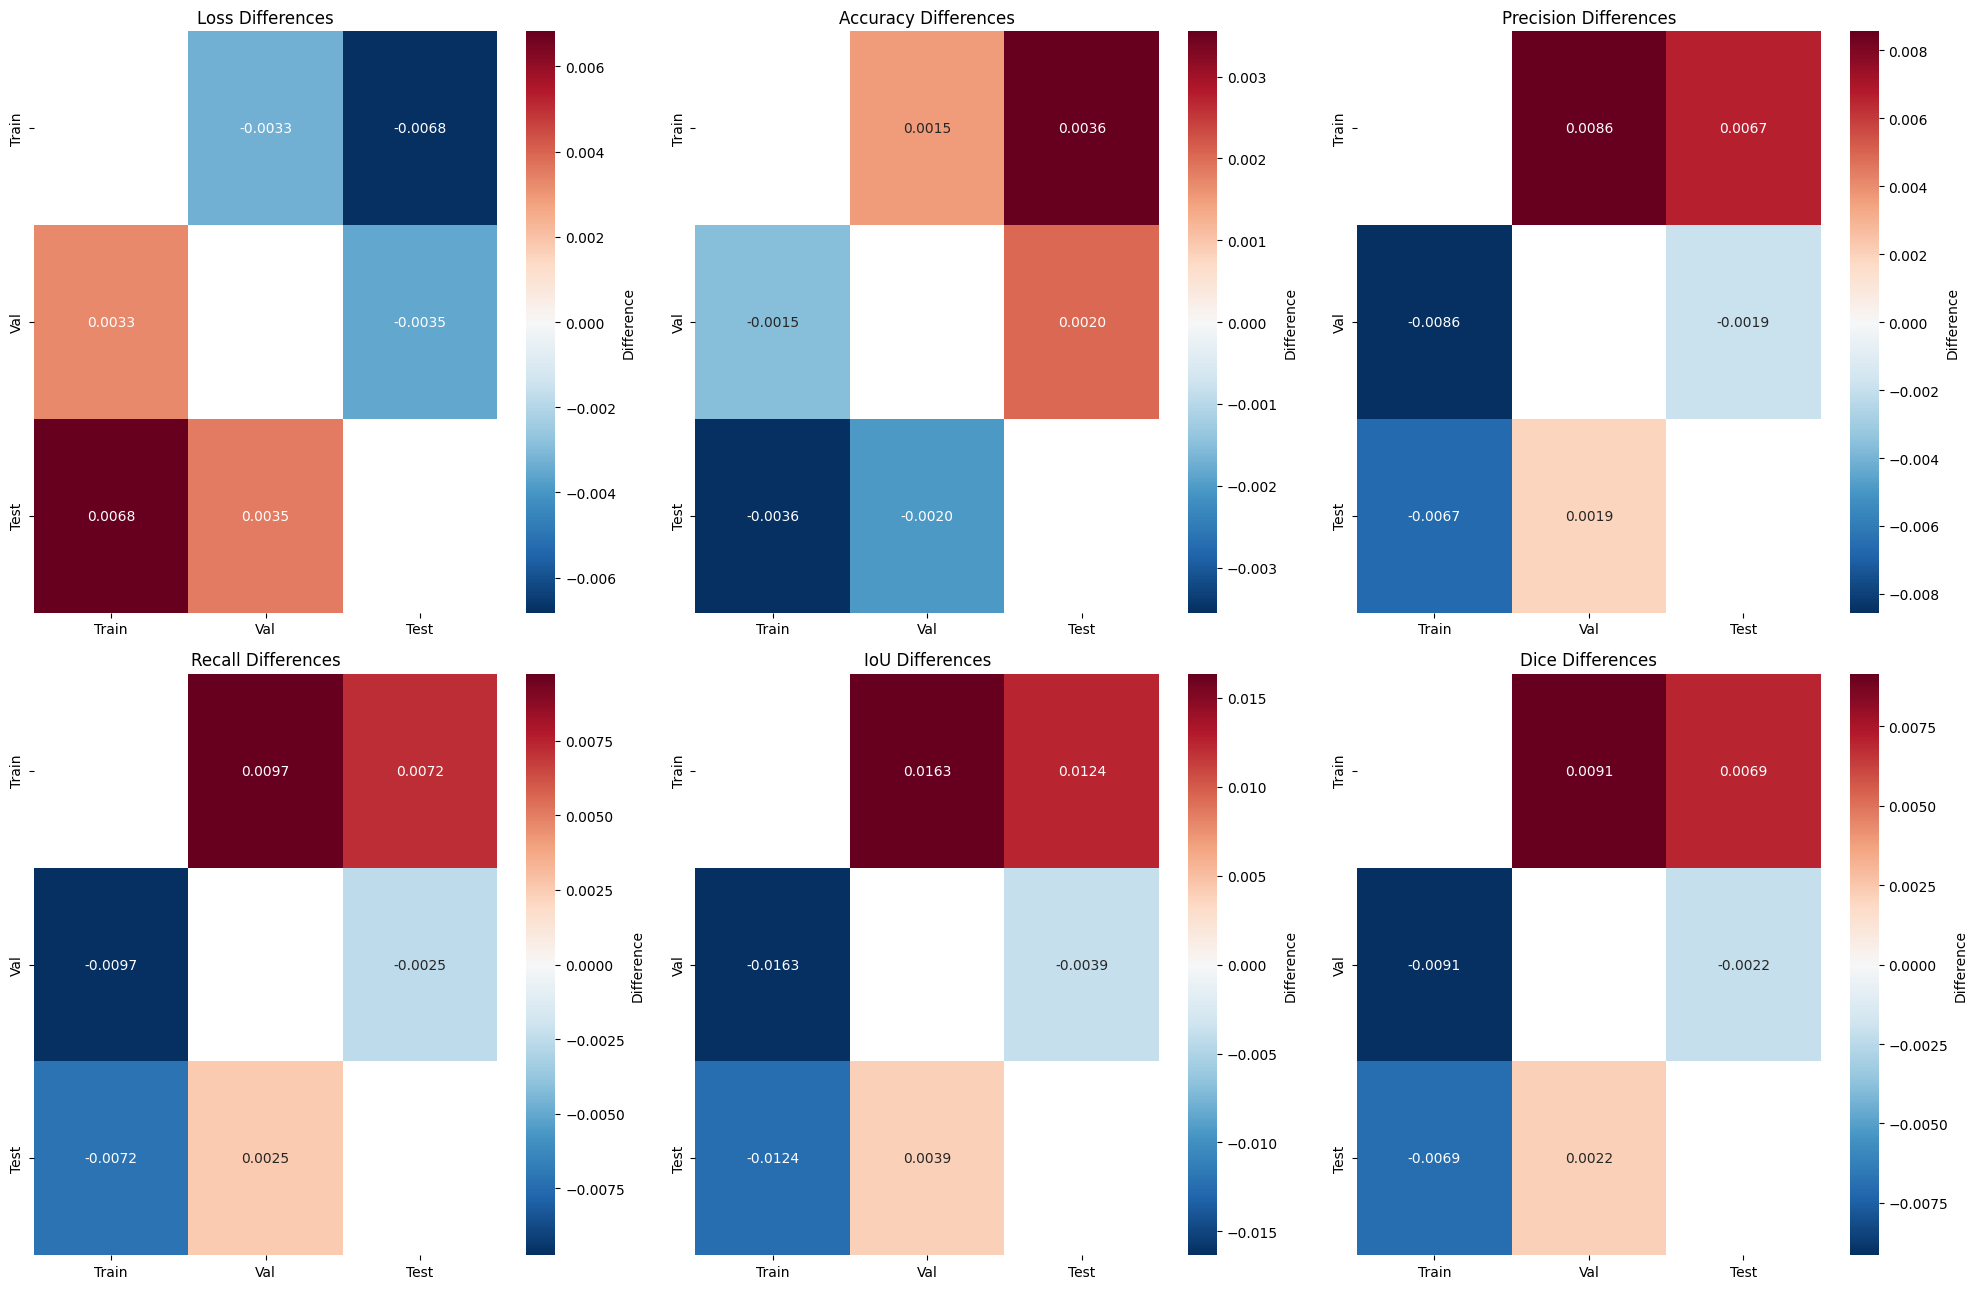


Detailed Metrics Differences Analysis:
----------------------------------------------------------------------

Loss Differences:
----------------------------------------
Train vs Val: -0.0033
Train vs Test: -0.0068
Val vs Test: -0.0035

Accuracy Differences:
----------------------------------------
Train vs Val: +0.0015
Train vs Test: +0.0036
Val vs Test: +0.0020

Precision Differences:
----------------------------------------
Train vs Val: +0.0086
Train vs Test: +0.0067
Val vs Test: -0.0019

Recall Differences:
----------------------------------------
Train vs Val: +0.0097
Train vs Test: +0.0072
Val vs Test: -0.0025

IoU Differences:
----------------------------------------
Train vs Val: +0.0163
Train vs Test: +0.0124
Val vs Test: -0.0039

Dice Differences:
----------------------------------------
Train vs Val: +0.0091
Train vs Test: +0.0069
Val vs Test: -0.0022


In [15]:
def calculate_differences(results, metrics):
    datasets = ['Train', 'Val', 'Test']
    diff_matrix = np.zeros((len(metrics), len(datasets), len(datasets)))
    for i in range(len(metrics)):
        for j, d1 in enumerate(datasets):
            for k, d2 in enumerate(datasets):
                if j != k:
                    diff_matrix[i, j, k] = results[d1.lower()][i] - results[d2.lower()][i]
    return diff_matrix

diff_matrix = calculate_differences(results_dict, metrics_names)
datasets = ['Train', 'Val', 'Test']
fig, axes = plt.subplots(2, 3, figsize=(20, 13))
axes = axes.ravel()

for i, metric in enumerate(metrics_names):
    mask = np.eye(len(datasets), dtype=bool)
    sns.heatmap(diff_matrix[i], annot=True, fmt='.4f', cmap='RdBu_r', center=0,
                mask=mask, xticklabels=datasets, yticklabels=datasets, ax=axes[i],
                cbar_kws={'label': 'Difference'})
    axes[i].set_title(f'{metric} Differences')

plt.tight_layout(); plt.show()

# Print detailed analysis
print("\nDetailed Metrics Differences Analysis:")
print("-" * 70)
for i, metric in enumerate(metrics_names):
    print(f"\n{metric} Differences:")
    print("-" * 40)
    for j, d1 in enumerate(datasets):
        for k, d2 in enumerate(datasets):
            if j < k:
                diff = diff_matrix[i, j, k]
                print(f"{d1} vs {d2}: {diff:+.4f}")
                if abs(diff) > 0.1:
                    print(f"   ⚠️ Large difference detected!")
                    if diff > 0:
                        print(f"   • {d1} performs better than {d2}")
                    else:
                        print(f"   • {d2} performs better than {d1}")